In [1]:
import qcportal as ptl
import os
import cmiles
from openeye import oechem

# Get some random molecule to use as an example

In [2]:
client = ptl.FractalClient()  
ds = client.get_collection("TorsionDriveDataset", "OpenFF Gen 2 Torsion Set 1 Roche 2")
ds.status(["default"], collapse=False, status="COMPLETE")

,default
c1cn[c:1]([nH]1)[CH2:2][C@H:3]2CCCC[C@@H:4]2O,COMPLETE
c1cc[c:1](cc1)[CH2:2][CH2:3][F:4],COMPLETE
[CH3:4][CH2:3][C:2]1([CH2:1]OC1)C,COMPLETE
[H:1][CH2:2][C@:3]([H:4])(c1ccccc1)C(=O)N(C)C,COMPLETE
[H:1][CH2:2][C:3]([H:4])(c1ccccc1)c2ccccc2,COMPLETE
...,...
[CH3:1][N@@:2](c1ccccc1)[S:3](=O)(=O)[CH3:4],COMPLETE
[CH3:4][NH:3][S:2](=O)(=O)[c:1]1ccccc1,COMPLETE
c1cc[c:1](cc1)[S:2](=O)(=O)[N:3]2[CH2:4]CCC2,COMPLETE
C[N:2]([CH3:1])[S:3](=O)(=[O:4])c1ccccn1,COMPLETE


In [88]:
oemol = None
dihedrals = None

# take the first molecule
tdr = ds.df.loc[ds.df.index[1], "default"]
        
min_idx = min(tdr.final_energy_dict, key=tdr.final_energy_dict.get)
record = tdr.get_history(min_idx, minimum=True)

# get optimized molecule of the record
qc_mol = record.get_final_molecule()

# convert the qcelemental molecule to an OpenEye molecule
qcjson_mol = qc_mol.dict(encoding='json')
oemol = cmiles.utils.load_molecule(qcjson_mol)

dihedrals = tdr.keywords.dihedrals[0]

dihedrals, oemol

((5, 6, 7, 8),
 <oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f497abebdb0> >)

# Get wbo from xtb

In [89]:
def get_xtb_wbo(oemol, idx1, idx2):
    '''
    mol:  OEMol to calculate wbo for
    idx1: index of first molecule
    idx2: index of second molecule
    
    returns a float for wbo between the atoms specified by idx1, idx2
    '''

    # make a temporary folder -- xtb creates extra files but I want to clean those up
    tmpdir = "_xtbtmpdir"
    if not os.path.exists(tmpdir):
        os.makedirs(tmpdir)
    os.chdir(tmpdir)

    # make some temporary files to run xtb
    tmpfile = '_xtbtmp.sdf'
    ofs = oechem.oemolostream()
    if not ofs.open(tmpfile):
        oechem.OEThrow.Fatal("Unable to open %s for writing" % outfile)

    # make a copy of the molecule
    molcopy = oechem.OEMol(oemol)

    # add title
    molcopy.SetTitle("xD")

    #molcopy.SetCoords(qc_mol.geometry.flatten()/1.6299)
    
    # write molecule to file
    oechem.OEWriteConstMolecule(ofs, molcopy)
    os.system("cp _xtbtmp.sdf ..")
    # close ofs
    ofs.close()

    # run xtb
    os.system("xtb _xtbtmp.sdf --charge-0 > out")

    # xtb output is 1-based, so we add 1 to our 0-based indices
    idxs = (idx1+1, idx2+1)

    # our return value
    wbo = None
    
    # go back
    os.chdir("../")
    
    # xtb creates a files called "wbo" with all our information
    with open(f"{tmpdir}/wbo", "r") as wbofile:
        for line in wbofile:
            mol1, mol2, wbo_ = line.split()
            mol1 = int(mol1)
            mol2 = int(mol2)
            wbo_ = float(wbo_)

            # if the indices match with the current line, we found our wbo
            if (mol1,mol2) == idxs or (mol2, mol1) == idxs:
                found = True
                wbo = wbo_
                break
        if wbo is None:
            # if we got here and wbo not found: probably never gonna happen but just in case
            raise Exception(f"No wbo for indices {idx1}, {idx2}")

    # and delete all the temporary files -- comment out to examine outputs
    os.system(f"rm -rf {tmpdir}")
    
    return wbo


In [90]:
get_xtb_wbo(oemol, dihedrals[1], dihedrals[2])

0.9927071966442192

# qcengine makes this easy

In [82]:
import qcelemental as qcel
import qcengine as qcng

def get_xtb_wbo_qce(qcmol, idx1, idx2):
    
    # xtb model
    model = qcel.models.AtomicInput(
        molecule=qcmol,
        driver="energy",
        model={"method": "GFN2-xTB"},    
    )

    # result of single point energy calculation
    result = qcng.compute(model, "xtb")

    return result.extras["xtb"]["mayer_indices"][idx1, idx2]

In [91]:
get_xtb_wbo_qce(qc_mol, dihedrals[1], dihedrals[2])

0.9927275610757244

# but are they actually the same?

In [109]:
xtb = []
qce = []
xs = []

for i, index in enumerate(ds.df.index):

    # get the record of each entry
    tdr = ds.get_record(name=index, specification='default')

    if tdr.status == "COMPLETE":
        xs.append(i)
        min_idx = min(tdr.final_energy_dict, key=tdr.final_energy_dict.get)
        record = tdr.get_history(min_idx, minimum=True)
        # get optimized molecule of the record
        qc_mol = record.get_final_molecule()

        # convert the qcelemental molecule to an OpenEye molecule
        qcjson_mol = qc_mol.dict(encoding='json')
        oemol = cmiles.utils.load_molecule(qcjson_mol)

        # get torsion atoms
        dihedrals = tdr.keywords.dihedrals[0]


        xtb_ = get_xtb_wbo(oemol, dihedrals[1], dihedrals[2])
        qce_ = get_xtb_wbo_qce(qc_mol, dihedrals[1], dihedrals[2])
        xtb.append(xtb_)
        qce.append(qce_)

In [112]:
import matplotlib.pyplot as plt

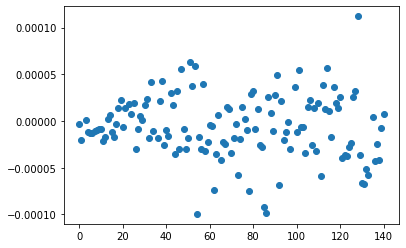

In [113]:
plt.scatter(xs, np.array(xtb) - np.array(qce))
plt.show()